In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
# !pip list

Package                            Version             Editable project location
---------------------------------- ------------------- -------------------------
absl-py                            1.4.0
accelerate                         0.34.2
aiohappyeyeballs                   2.4.3
aiohttp                            3.10.10
aiosignal                          1.3.1
alabaster                          0.7.16
albucore                           0.0.19
albumentations                     1.3.1
altair                             4.2.2
annotated-types                    0.7.0
antlr4-python3-runtime             4.9.3
anyio                              3.7.1
arabic-reshaper                    3.0.0
argon2-cffi                        23.1.0
argon2-cffi-bindings               21.2.0
array_record                       0.5.1
arviz                              0.20.0
asn1crypto                         1.5.1
astropy                            6.1.4
astropy-iers-data                  0.2024.10.28.0.3

In [ ]:
import gc
import os
import torch
import numpy as np

os.makedirs('/content/gdrive/MyDrive/Colab Notebooks/YOLO/YOLO NAS/predictions', exist_ok=True)

In [ ]:
CLASS_NAMES = [
    'crazing',
    'inclusion',
    'patches',
    'pitted_surface',
    'rolled-in_scale',
    'scratches'
]
NUM_CLASSES = len(CLASS_NAMES)

In [ ]:
from super_gradients.training.datasets.detection_datasets.coco_format_detection import COCOFormatDetectionDataset
from super_gradients.training.transforms.transforms import (
    DetectionRandomAffine,
    DetectionHSV,
    DetectionHorizontalFlip,
    DetectionPaddedRescale,
    DetectionStandardize,
    DetectionTargetsFormatTransform,
)
from super_gradients.training.utils.collate_fn import DetectionCollateFN

from super_gradients.training import Trainer, dataloaders, models
from super_gradients.training.dataloaders.dataloaders import (
    coco_detection_yolo_format_train, coco_detection_yolo_format_val
)
from super_gradients.training.losses import PPYoloELoss
from super_gradients.training.metrics import DetectionMetrics_050
from super_gradients.training.models.detection_models.pp_yolo_e import (
    PPYoloEPostPredictionCallback
)

[2024-11-11 00:42:15] INFO - crash_tips_setup.py - Crash tips is enabled. You can set your environment variable to CRASH_HANDLER=FALSE to disable it


The console stream is logged into /root/sg_logs/console.log


[2024-11-11 00:42:21] INFO - utils.py - NumExpr defaulting to 2 threads.


In [ ]:
from torch.utils.data import DataLoader

NUM_WORKERS = 0
BATCH_SIZE = 16

train_dataloader_params = {
    "shuffle": True,
    "batch_size": BATCH_SIZE,
    "drop_last": True,
    "pin_memory": True,
    "collate_fn": DetectionCollateFN(),
    "num_workers": NUM_WORKERS,
    "persistent_workers": NUM_WORKERS > 0,
}

val_dataloader_params = {
    "shuffle": False,
    "batch_size": BATCH_SIZE,
    "drop_last": False,
    "pin_memory": True,
    "collate_fn": DetectionCollateFN(),
    "num_workers": NUM_WORKERS,
    "persistent_workers": NUM_WORKERS > 0,
}

In [ ]:
train_data = coco_detection_yolo_format_train(
    dataset_params={
        'data_dir': '/content/gdrive/MyDrive/Colab Notebooks/YOLO/NEU dataset',
        'images_dir': '/content/gdrive/MyDrive/Colab Notebooks/YOLO/NEU dataset/train/images',
        'labels_dir': '/content/gdrive/MyDrive/Colab Notebooks/YOLO/NEU dataset/train/labels',
        'classes': CLASS_NAMES
    },
    dataloader_params=train_dataloader_params
)
val_data = coco_detection_yolo_format_train(
    dataset_params={
        'data_dir': '/content/gdrive/MyDrive/Colab Notebooks/YOLO/NEU dataset',
        'images_dir': '/content/gdrive/MyDrive/Colab Notebooks/YOLO/NEU dataset/valid/images',
        'labels_dir': '/content/gdrive/MyDrive/Colab Notebooks/YOLO/NEU dataset/valid/labels',
        'classes': CLASS_NAMES
    },
    dataloader_params=val_dataloader_params
)

[2024-11-11 00:42:33] INFO - detection_dataset.py - Dataset Initialization in progress. `cache_annotations=True` causes the process to take longer due to full dataset indexing.
Indexing dataset annotations: 100%|██████████| 1260/1260 [00:17<00:00, 73.57it/s] 
[2024-11-11 00:42:50] INFO - detection_dataset.py - Dataset Initialization in progress. `cache_annotations=True` causes the process to take longer due to full dataset indexing.
Indexing dataset annotations: 100%|██████████| 270/270 [00:02<00:00, 134.26it/s]


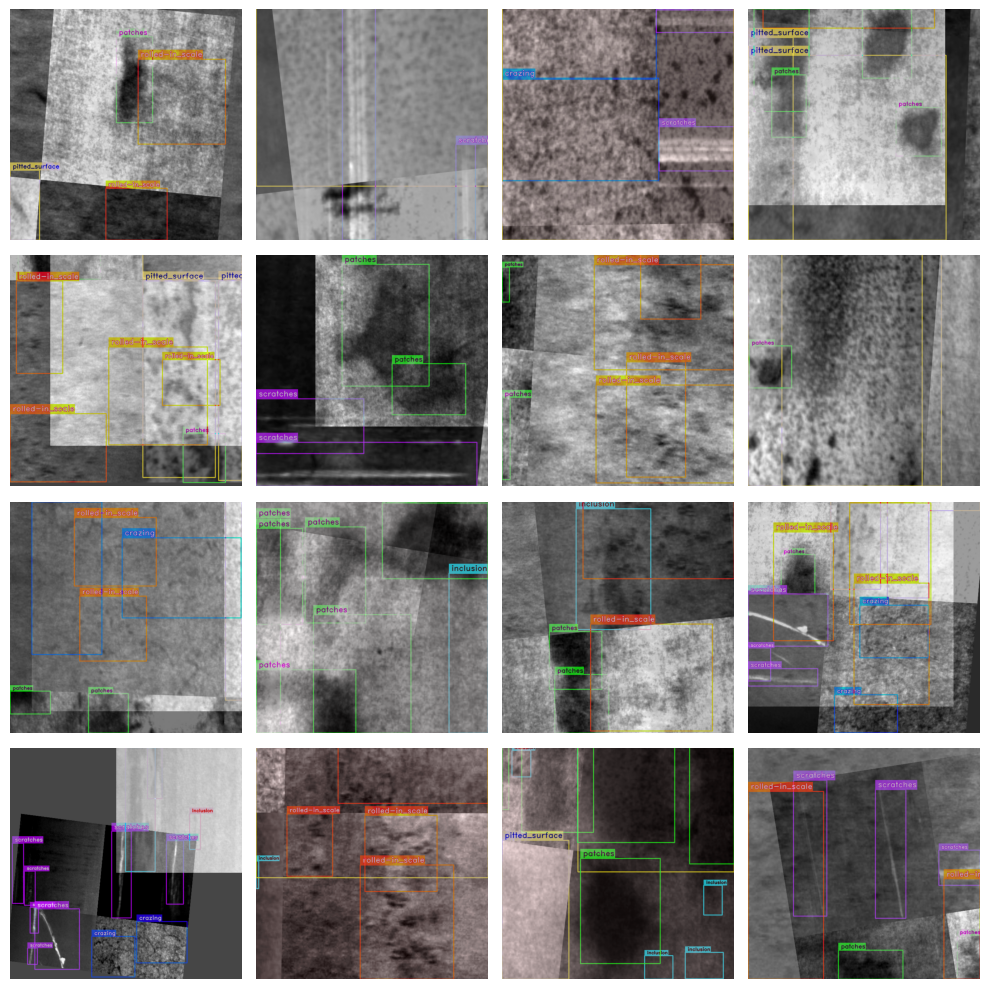

In [ ]:
train_data.dataset.plot()

In [ ]:
train_params = {
    # ENABLING SILENT MODE
    "average_best_models":True,
    "warmup_mode": "linear_epoch_step",
    "warmup_initial_lr": 1e-6,
    "lr_warmup_epochs": 3,
    "initial_lr": 5e-4,
    "lr_mode": "cosine",
    "cosine_final_lr_ratio": 0.1,
    "optimizer": "Adam",
    "optimizer_params": {"weight_decay": 0.0001},
    "zero_weight_decay_on_bias_and_bn": True,
    "ema": True,
    "ema_params": {"decay": 0.9, "decay_type": "threshold"},
    # ONLY TRAINING FOR 30 EPOCHS FOR THIS EXAMPLE NOTEBOOK
    "max_epochs": 30,
    "mixed_precision": True,
    "loss": PPYoloELoss(
        use_static_assigner=False,
        # NOTE: num_classes needs to be defined here
        num_classes=NUM_CLASSES,
        reg_max=16
    ),
    "valid_metrics_list": [
        DetectionMetrics_050(
            score_thres=0.1,
            top_k_predictions=300,
            # NOTE: num_classes needs to be defined here
            num_cls=NUM_CLASSES,
            normalize_targets=True,
            post_prediction_callback=PPYoloEPostPredictionCallback(
                score_threshold=0.01,
                nms_top_k=1000,
                max_predictions=300,
                nms_threshold=0.7
            )
        )
    ],
    "metric_to_watch": 'mAP@0.50'
}

In [ ]:
# !git clone https://github.com/Deci-AI/super-gradients.git

Cloning into 'super-gradients'...
remote: Enumerating objects: 48371, done.
remote: Counting objects: 100% (421/421), done.
remote: Compressing objects: 100% (222/222), done.
remote: Total 48371 (delta 219), reused 325 (delta 154), pack-reused 47950 (from 1)
Receiving objects: 100% (48371/48371), 415.56 MiB | 38.32 MiB/s, done.
Resolving deltas: 100% (32791/32791), done.


In [ ]:
# %cd super-gradients

Updating files: 100% (1185/1185), done.
/content/super-gradients


In [ ]:
# !pip install -e .

Obtaining file:///content/super-gradients
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 20.7 MB/s eta 0:00:00
  Building editable for super-gradients (pyproject.toml) ... done
  Created wheel for super-gradients: filename=super_gradients-3.7.1+master-0.editable-py3-none-any.whl size=18802 sha256=ecf3b81755a15919552d726b84b5ba81b0a4f2908b1604e55ff5860337d7676d
  Stored in directory: /tmp/pip-ephem-wheel-cache-7xsojy7y/wheels/c9/b1/76/a1c4ad7d7328bf848ae8d3806c2c9d70af5545ad278dd0fa11
Successfully built super-gradients
  Attempting uninstall: setuptools
    Found existing installation: setuptools 75.1.0
    Uninstalling setuptools-75.1.0:
      Successfully uninstalled setuptools-75.1.0
  Attempting uninstall: super-gradients
    Found existing installation: super-gradients 

In [ ]:
from super_gradients.common.object_names import Models

trainer = Trainer(experiment_name="NEU defect detection", ckpt_root_dir="/content/gdrive/MyDrive/Colab Notebooks/YOLO/YOLO NAS/train_models")
model = models.get(Models.YOLO_NAS_L, num_classes=NUM_CLASSES, pretrained_weights="coco")
trainer.train(model=model, training_params=train_params, train_loader=train_data, valid_loader=val_data)

[2024-11-11 00:43:34] WARNING - checkpoint_utils.py - :warning: The pre-trained models provided by SuperGradients may have their own licenses or terms and conditions derived from the dataset used for pre-training.
 It is your responsibility to determine whether you have permission to use the models for your use case.
 The model you have requested was pre-trained on the coco dataset, published under the following terms: https://cocodataset.org/#termsofuse
[2024-11-11 00:43:34] INFO - checkpoint_utils.py - License Notification: YOLO-NAS pre-trained weights are subjected to the specific license terms and conditions detailed in 
https://github.com/Deci-AI/super-gradients/blob/master/LICENSE.YOLONAS.md
By downloading the pre-trained weight files you agree to comply with these terms.
Downloading: "https://sg-hub-nv.s3.amazonaws.com/models/yolo_nas_l_coco.pth" to /root/.cache/torch/hub/checkpoints/yolo_nas_l_coco.pth
100%|██████████| 256M/256M [00:11<00:00, 24.2MB/s]
[2024-11-11 00:43:46] INF

The console stream is now moved to /content/gdrive/MyDrive/Colab Notebooks/YOLO/YOLO NAS/train_models/NEU defect detection/RUN_20241111_004346_879111/console_Nov11_00_43_47.txt


/content/super-gradients/src/super_gradients/common/registry/registry.py:72: DeprecationWarning: Object name `linear_epoch_step` is now deprecated. Please replace it with `LinearEpochLRWarmup`.
  warnings.warn(f"Object name `{name}` is now deprecated. Please replace it with `{deprecated_names[name]}`.", DeprecationWarning)
/content/super-gradients/src/super_gradients/training/utils/optimizer_utils.py:108: DeprecationWarning: initialize_param_groups and update_param_groups usages are deprecated since 3.4.0, will be removed in 3.5.0 and have no effect. 
 Assign different learning rates by passing a mapping of layer name prefixes to lr values through initial_lr training hyperparameter (i.e initial_lr={'backbone': 0.01, 'default':0.1})
  warnings.warn(
/content/super-gradients/src/super_gradients/training/sg_trainer/sg_trainer.py:1765: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = GradScaler(en

SUMMARY OF EPOCH 0
├── Train
│   ├── Ppyoloeloss/loss_cls = 2.064
│   ├── Ppyoloeloss/loss_iou = 0.8312
│   ├── Ppyoloeloss/loss_dfl = 0.9047
│   └── Ppyoloeloss/loss = 3.7999
└── Validation
    ├── Ppyoloeloss/loss_cls = 2.0306
    ├── Ppyoloeloss/loss_iou = 0.8221
    ├── Ppyoloeloss/loss_dfl = 0.9034
    ├── Ppyoloeloss/loss = 3.756
    ├── Precision@0.50 = 0.0
    ├── Recall@0.50 = 0.0
    ├── Map@0.50 = 0.0048
    ├── F1@0.50 = 0.0
    └── Best_score_threshold = 0.03



Validating epoch 1: 100%|██████████| 17/17 [00:29<00:00,  1.72s/it]
[2024-11-11 00:50:47] WARNING - sg_trainer.py - Could not set preprocessing pipeline from the validation dataset:
 get_equivalent_preprocessing is not implemented for non-deterministic transforms..
 Before callingpredict make sure to call set_dataset_processing_params.
[2024-11-11 00:50:56] INFO - base_sg_logger.py - Checkpoint saved in /content/gdrive/MyDrive/Colab Notebooks/YOLO/YOLO NAS/train_models/NEU defect detection/RUN_20241111_004346_879111/ckpt_best.pth
[2024-11-11 00:50:56] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50: 0.1387047916650772


SUMMARY OF EPOCH 1
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.4398
│   │   ├── Epoch N-1      = 2.064  (↘ -0.6243)
│   │   └── Best until now = 2.064  (↘ -0.6243)
│   ├── Ppyoloeloss/loss_iou = 0.7389
│   │   ├── Epoch N-1      = 0.8312 (↘ -0.0923)
│   │   └── Best until now = 0.8312 (↘ -0.0923)
│   ├── Ppyoloeloss/loss_dfl = 0.8385
│   │   ├── Epoch N-1      = 0.9047 (↘ -0.0662)
│   │   └── Best until now = 0.9047 (↘ -0.0662)
│   └── Ppyoloeloss/loss = 3.0172
│       ├── Epoch N-1      = 3.7999 (↘ -0.7828)
│       └── Best until now = 3.7999 (↘ -0.7828)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.8095
    │   ├── Epoch N-1      = 2.0306 (↘ -0.2211)
    │   └── Best until now = 2.0306 (↘ -0.2211)
    ├── Ppyoloeloss/loss_iou = 0.704
    │   ├── Epoch N-1      = 0.8221 (↘ -0.118)
    │   └── Best until now = 0.8221 (↘ -0.118)
    ├── Ppyoloeloss/loss_dfl = 0.8582
    │   ├── Epoch N-1      = 0.9034 (↘ -0.0452)
    │   └── Best until now = 0.9034 (↘ -0.0452)
    ├── Ppyoloeloss/loss 

Validating epoch 2: 100%|██████████| 17/17 [00:30<00:00,  1.78s/it]
[2024-11-11 00:54:31] WARNING - sg_trainer.py - Could not set preprocessing pipeline from the validation dataset:
 get_equivalent_preprocessing is not implemented for non-deterministic transforms..
 Before callingpredict make sure to call set_dataset_processing_params.
[2024-11-11 00:54:45] INFO - base_sg_logger.py - Checkpoint saved in /content/gdrive/MyDrive/Colab Notebooks/YOLO/YOLO NAS/train_models/NEU defect detection/RUN_20241111_004346_879111/ckpt_best.pth
[2024-11-11 00:54:45] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50: 0.1497272104024887


SUMMARY OF EPOCH 2
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.3099
│   │   ├── Epoch N-1      = 1.4398 (↘ -0.1298)
│   │   └── Best until now = 1.4398 (↘ -0.1298)
│   ├── Ppyoloeloss/loss_iou = 0.6938
│   │   ├── Epoch N-1      = 0.7389 (↘ -0.045)
│   │   └── Best until now = 0.7389 (↘ -0.045)
│   ├── Ppyoloeloss/loss_dfl = 0.8111
│   │   ├── Epoch N-1      = 0.8385 (↘ -0.0274)
│   │   └── Best until now = 0.8385 (↘ -0.0274)
│   └── Ppyoloeloss/loss = 2.8149
│       ├── Epoch N-1      = 3.0172 (↘ -0.2023)
│       └── Best until now = 3.0172 (↘ -0.2023)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.3709
    │   ├── Epoch N-1      = 1.8095 (↘ -0.4385)
    │   └── Best until now = 1.8095 (↘ -0.4385)
    ├── Ppyoloeloss/loss_iou = 0.6676
    │   ├── Epoch N-1      = 0.704  (↘ -0.0365)
    │   └── Best until now = 0.704  (↘ -0.0365)
    ├── Ppyoloeloss/loss_dfl = 0.8259
    │   ├── Epoch N-1      = 0.8582 (↘ -0.0323)
    │   └── Best until now = 0.8582 (↘ -0.0323)
    ├── Ppyoloeloss/loss

Validating epoch 3: 100%|██████████| 17/17 [00:29<00:00,  1.73s/it]
[2024-11-11 00:58:25] WARNING - sg_trainer.py - Could not set preprocessing pipeline from the validation dataset:
 get_equivalent_preprocessing is not implemented for non-deterministic transforms..
 Before callingpredict make sure to call set_dataset_processing_params.


SUMMARY OF EPOCH 3
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.3056
│   │   ├── Epoch N-1      = 1.3099 (↘ -0.0043)
│   │   └── Best until now = 1.3099 (↘ -0.0043)
│   ├── Ppyoloeloss/loss_iou = 0.6755
│   │   ├── Epoch N-1      = 0.6938 (↘ -0.0183)
│   │   └── Best until now = 0.6938 (↘ -0.0183)
│   ├── Ppyoloeloss/loss_dfl = 0.8038
│   │   ├── Epoch N-1      = 0.8111 (↘ -0.0073)
│   │   └── Best until now = 0.8111 (↘ -0.0073)
│   └── Ppyoloeloss/loss = 2.785
│       ├── Epoch N-1      = 2.8149 (↘ -0.0299)
│       └── Best until now = 2.8149 (↘ -0.0299)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.4144
    │   ├── Epoch N-1      = 1.3709 (↗ 0.0435)
    │   └── Best until now = 1.3709 (↗ 0.0435)
    ├── Ppyoloeloss/loss_iou = 0.6845
    │   ├── Epoch N-1      = 0.6676 (↗ 0.017)
    │   └── Best until now = 0.6676 (↗ 0.017)
    ├── Ppyoloeloss/loss_dfl = 0.8394
    │   ├── Epoch N-1      = 0.8259 (↗ 0.0134)
    │   └── Best until now = 0.8259 (↗ 0.0134)
    ├── Ppyoloeloss/loss = 2.93

Validating epoch 4: 100%|██████████| 17/17 [00:29<00:00,  1.75s/it]
[2024-11-11 01:02:05] WARNING - sg_trainer.py - Could not set preprocessing pipeline from the validation dataset:
 get_equivalent_preprocessing is not implemented for non-deterministic transforms..
 Before callingpredict make sure to call set_dataset_processing_params.
[2024-11-11 01:02:24] INFO - base_sg_logger.py - Checkpoint saved in /content/gdrive/MyDrive/Colab Notebooks/YOLO/YOLO NAS/train_models/NEU defect detection/RUN_20241111_004346_879111/ckpt_best.pth
[2024-11-11 01:02:24] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50: 0.2209947109222412


SUMMARY OF EPOCH 4
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.2873
│   │   ├── Epoch N-1      = 1.3056 (↘ -0.0184)
│   │   └── Best until now = 1.3056 (↘ -0.0184)
│   ├── Ppyoloeloss/loss_iou = 0.6455
│   │   ├── Epoch N-1      = 0.6755 (↘ -0.03)
│   │   └── Best until now = 0.6755 (↘ -0.03)
│   ├── Ppyoloeloss/loss_dfl = 0.7888
│   │   ├── Epoch N-1      = 0.8038 (↘ -0.015)
│   │   └── Best until now = 0.8038 (↘ -0.015)
│   └── Ppyoloeloss/loss = 2.7216
│       ├── Epoch N-1      = 2.785  (↘ -0.0634)
│       └── Best until now = 2.785  (↘ -0.0634)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.2807
    │   ├── Epoch N-1      = 1.4144 (↘ -0.1337)
    │   └── Best until now = 1.3709 (↘ -0.0902)
    ├── Ppyoloeloss/loss_iou = 0.6505
    │   ├── Epoch N-1      = 0.6845 (↘ -0.034)
    │   └── Best until now = 0.6676 (↘ -0.017)
    ├── Ppyoloeloss/loss_dfl = 0.7868
    │   ├── Epoch N-1      = 0.8394 (↘ -0.0526)
    │   └── Best until now = 0.8259 (↘ -0.0391)
    ├── Ppyoloeloss/loss = 2.7

Validating epoch 5: 100%|██████████| 17/17 [00:30<00:00,  1.78s/it]
[2024-11-11 01:06:14] WARNING - sg_trainer.py - Could not set preprocessing pipeline from the validation dataset:
 get_equivalent_preprocessing is not implemented for non-deterministic transforms..
 Before callingpredict make sure to call set_dataset_processing_params.
[2024-11-11 01:06:42] INFO - base_sg_logger.py - Checkpoint saved in /content/gdrive/MyDrive/Colab Notebooks/YOLO/YOLO NAS/train_models/NEU defect detection/RUN_20241111_004346_879111/ckpt_best.pth
[2024-11-11 01:06:42] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50: 0.23504209518432617


SUMMARY OF EPOCH 5
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.2832
│   │   ├── Epoch N-1      = 1.2873 (↘ -0.0041)
│   │   └── Best until now = 1.2873 (↘ -0.0041)
│   ├── Ppyoloeloss/loss_iou = 0.6246
│   │   ├── Epoch N-1      = 0.6455 (↘ -0.0209)
│   │   └── Best until now = 0.6455 (↘ -0.0209)
│   ├── Ppyoloeloss/loss_dfl = 0.7703
│   │   ├── Epoch N-1      = 0.7888 (↘ -0.0186)
│   │   └── Best until now = 0.7888 (↘ -0.0186)
│   └── Ppyoloeloss/loss = 2.6781
│       ├── Epoch N-1      = 2.7216 (↘ -0.0435)
│       └── Best until now = 2.7216 (↘ -0.0435)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.2996
    │   ├── Epoch N-1      = 1.2807 (↗ 0.0189)
    │   └── Best until now = 1.2807 (↗ 0.0189)
    ├── Ppyoloeloss/loss_iou = 0.6173
    │   ├── Epoch N-1      = 0.6505 (↘ -0.0332)
    │   └── Best until now = 0.6505 (↘ -0.0332)
    ├── Ppyoloeloss/loss_dfl = 0.7651
    │   ├── Epoch N-1      = 0.7868 (↘ -0.0217)
    │   └── Best until now = 0.7868 (↘ -0.0217)
    ├── Ppyoloeloss/loss

Validating epoch 6: 100%|██████████| 17/17 [00:30<00:00,  1.78s/it]
[2024-11-11 01:10:40] WARNING - sg_trainer.py - Could not set preprocessing pipeline from the validation dataset:
 get_equivalent_preprocessing is not implemented for non-deterministic transforms..
 Before callingpredict make sure to call set_dataset_processing_params.
[2024-11-11 01:10:48] INFO - base_sg_logger.py - Checkpoint saved in /content/gdrive/MyDrive/Colab Notebooks/YOLO/YOLO NAS/train_models/NEU defect detection/RUN_20241111_004346_879111/ckpt_best.pth
[2024-11-11 01:10:48] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50: 0.25060370564460754


SUMMARY OF EPOCH 6
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.2666
│   │   ├── Epoch N-1      = 1.2832 (↘ -0.0166)
│   │   └── Best until now = 1.2832 (↘ -0.0166)
│   ├── Ppyoloeloss/loss_iou = 0.604
│   │   ├── Epoch N-1      = 0.6246 (↘ -0.0207)
│   │   └── Best until now = 0.6246 (↘ -0.0207)
│   ├── Ppyoloeloss/loss_dfl = 0.7494
│   │   ├── Epoch N-1      = 0.7703 (↘ -0.0209)
│   │   └── Best until now = 0.7703 (↘ -0.0209)
│   └── Ppyoloeloss/loss = 2.6199
│       ├── Epoch N-1      = 2.6781 (↘ -0.0582)
│       └── Best until now = 2.6781 (↘ -0.0582)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.2987
    │   ├── Epoch N-1      = 1.2996 (↘ -0.0009)
    │   └── Best until now = 1.2807 (↗ 0.018)
    ├── Ppyoloeloss/loss_iou = 0.6054
    │   ├── Epoch N-1      = 0.6173 (↘ -0.0119)
    │   └── Best until now = 0.6173 (↘ -0.0119)
    ├── Ppyoloeloss/loss_dfl = 0.7662
    │   ├── Epoch N-1      = 0.7651 (↗ 0.0011)
    │   └── Best until now = 0.7651 (↗ 0.0011)
    ├── Ppyoloeloss/loss = 

Validating epoch 7: 100%|██████████| 17/17 [00:30<00:00,  1.79s/it]
[2024-11-11 01:15:01] WARNING - sg_trainer.py - Could not set preprocessing pipeline from the validation dataset:
 get_equivalent_preprocessing is not implemented for non-deterministic transforms..
 Before callingpredict make sure to call set_dataset_processing_params.
[2024-11-11 01:15:17] INFO - base_sg_logger.py - Checkpoint saved in /content/gdrive/MyDrive/Colab Notebooks/YOLO/YOLO NAS/train_models/NEU defect detection/RUN_20241111_004346_879111/ckpt_best.pth
[2024-11-11 01:15:17] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50: 0.2869205176830292


SUMMARY OF EPOCH 7
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.2511
│   │   ├── Epoch N-1      = 1.2666 (↘ -0.0155)
│   │   └── Best until now = 1.2666 (↘ -0.0155)
│   ├── Ppyoloeloss/loss_iou = 0.6019
│   │   ├── Epoch N-1      = 0.604  (↘ -0.0021)
│   │   └── Best until now = 0.604  (↘ -0.0021)
│   ├── Ppyoloeloss/loss_dfl = 0.7495
│   │   ├── Epoch N-1      = 0.7494 (↗ 1e-04)
│   │   └── Best until now = 0.7494 (↗ 1e-04)
│   └── Ppyoloeloss/loss = 2.6024
│       ├── Epoch N-1      = 2.6199 (↘ -0.0175)
│       └── Best until now = 2.6199 (↘ -0.0175)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.2559
    │   ├── Epoch N-1      = 1.2987 (↘ -0.0428)
    │   └── Best until now = 1.2807 (↘ -0.0248)
    ├── Ppyoloeloss/loss_iou = 0.6006
    │   ├── Epoch N-1      = 0.6054 (↘ -0.0048)
    │   └── Best until now = 0.6054 (↘ -0.0048)
    ├── Ppyoloeloss/loss_dfl = 0.744
    │   ├── Epoch N-1      = 0.7662 (↘ -0.0222)
    │   └── Best until now = 0.7651 (↘ -0.0211)
    ├── Ppyoloeloss/loss = 

Validating epoch 8: 100%|██████████| 17/17 [00:29<00:00,  1.74s/it]
[2024-11-11 01:19:34] WARNING - sg_trainer.py - Could not set preprocessing pipeline from the validation dataset:
 get_equivalent_preprocessing is not implemented for non-deterministic transforms..
 Before callingpredict make sure to call set_dataset_processing_params.


SUMMARY OF EPOCH 8
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.2679
│   │   ├── Epoch N-1      = 1.2511 (↗ 0.0168)
│   │   └── Best until now = 1.2511 (↗ 0.0168)
│   ├── Ppyoloeloss/loss_iou = 0.5944
│   │   ├── Epoch N-1      = 0.6019 (↘ -0.0074)
│   │   └── Best until now = 0.6019 (↘ -0.0074)
│   ├── Ppyoloeloss/loss_dfl = 0.7482
│   │   ├── Epoch N-1      = 0.7495 (↘ -0.0012)
│   │   └── Best until now = 0.7494 (↘ -0.0011)
│   └── Ppyoloeloss/loss = 2.6106
│       ├── Epoch N-1      = 2.6024 (↗ 0.0082)
│       └── Best until now = 2.6024 (↗ 0.0082)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.4183
    │   ├── Epoch N-1      = 1.2559 (↗ 0.1623)
    │   └── Best until now = 1.2559 (↗ 0.1623)
    ├── Ppyoloeloss/loss_iou = 0.6387
    │   ├── Epoch N-1      = 0.6006 (↗ 0.0381)
    │   └── Best until now = 0.6006 (↗ 0.0381)
    ├── Ppyoloeloss/loss_dfl = 0.7989
    │   ├── Epoch N-1      = 0.744  (↗ 0.0549)
    │   └── Best until now = 0.744  (↗ 0.0549)
    ├── Ppyoloeloss/loss = 2.855

Validating epoch 9: 100%|██████████| 17/17 [00:30<00:00,  1.79s/it]
[2024-11-11 01:24:17] WARNING - sg_trainer.py - Could not set preprocessing pipeline from the validation dataset:
 get_equivalent_preprocessing is not implemented for non-deterministic transforms..
 Before callingpredict make sure to call set_dataset_processing_params.
[2024-11-11 01:24:36] INFO - base_sg_logger.py - Checkpoint saved in /content/gdrive/MyDrive/Colab Notebooks/YOLO/YOLO NAS/train_models/NEU defect detection/RUN_20241111_004346_879111/ckpt_best.pth
[2024-11-11 01:24:36] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50: 0.28773558139801025


SUMMARY OF EPOCH 9
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.2537
│   │   ├── Epoch N-1      = 1.2679 (↘ -0.0142)
│   │   └── Best until now = 1.2511 (↗ 0.0026)
│   ├── Ppyoloeloss/loss_iou = 0.5848
│   │   ├── Epoch N-1      = 0.5944 (↘ -0.0096)
│   │   └── Best until now = 0.5944 (↘ -0.0096)
│   ├── Ppyoloeloss/loss_dfl = 0.7363
│   │   ├── Epoch N-1      = 0.7482 (↘ -0.0119)
│   │   └── Best until now = 0.7482 (↘ -0.0119)
│   └── Ppyoloeloss/loss = 2.5748
│       ├── Epoch N-1      = 2.6106 (↘ -0.0358)
│       └── Best until now = 2.6024 (↘ -0.0276)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.2774
    │   ├── Epoch N-1      = 1.4183 (↘ -0.1409)
    │   └── Best until now = 1.2559 (↗ 0.0214)
    ├── Ppyoloeloss/loss_iou = 0.5951
    │   ├── Epoch N-1      = 0.6387 (↘ -0.0436)
    │   └── Best until now = 0.6006 (↘ -0.0055)
    ├── Ppyoloeloss/loss_dfl = 0.7487
    │   ├── Epoch N-1      = 0.7989 (↘ -0.0502)
    │   └── Best until now = 0.744  (↗ 0.0047)
    ├── Ppyoloeloss/loss 

Validating epoch 10: 100%|██████████| 17/17 [00:30<00:00,  1.77s/it]
[2024-11-11 01:29:15] WARNING - sg_trainer.py - Could not set preprocessing pipeline from the validation dataset:
 get_equivalent_preprocessing is not implemented for non-deterministic transforms..
 Before callingpredict make sure to call set_dataset_processing_params.
[2024-11-11 01:29:48] INFO - base_sg_logger.py - Checkpoint saved in /content/gdrive/MyDrive/Colab Notebooks/YOLO/YOLO NAS/train_models/NEU defect detection/RUN_20241111_004346_879111/ckpt_best.pth
[2024-11-11 01:29:48] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50: 0.3100874722003937


SUMMARY OF EPOCH 10
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.2349
│   │   ├── Epoch N-1      = 1.2537 (↘ -0.0188)
│   │   └── Best until now = 1.2511 (↘ -0.0161)
│   ├── Ppyoloeloss/loss_iou = 0.5744
│   │   ├── Epoch N-1      = 0.5848 (↘ -0.0104)
│   │   └── Best until now = 0.5848 (↘ -0.0104)
│   ├── Ppyoloeloss/loss_dfl = 0.7294
│   │   ├── Epoch N-1      = 0.7363 (↘ -0.0069)
│   │   └── Best until now = 0.7363 (↘ -0.0069)
│   └── Ppyoloeloss/loss = 2.5388
│       ├── Epoch N-1      = 2.5748 (↘ -0.036)
│       └── Best until now = 2.5748 (↘ -0.036)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.2285
    │   ├── Epoch N-1      = 1.2774 (↘ -0.0489)
    │   └── Best until now = 1.2559 (↘ -0.0275)
    ├── Ppyoloeloss/loss_iou = 0.5843
    │   ├── Epoch N-1      = 0.5951 (↘ -0.0107)
    │   └── Best until now = 0.5951 (↘ -0.0107)
    ├── Ppyoloeloss/loss_dfl = 0.7441
    │   ├── Epoch N-1      = 0.7487 (↘ -0.0046)
    │   └── Best until now = 0.744  (↗ 1e-04)
    ├── Ppyoloeloss/loss 

Validating epoch 11: 100%|██████████| 17/17 [00:30<00:00,  1.80s/it]
[2024-11-11 01:34:15] WARNING - sg_trainer.py - Could not set preprocessing pipeline from the validation dataset:
 get_equivalent_preprocessing is not implemented for non-deterministic transforms..
 Before callingpredict make sure to call set_dataset_processing_params.


SUMMARY OF EPOCH 11
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.2333
│   │   ├── Epoch N-1      = 1.2349 (↘ -0.0017)
│   │   └── Best until now = 1.2349 (↘ -0.0017)
│   ├── Ppyoloeloss/loss_iou = 0.5718
│   │   ├── Epoch N-1      = 0.5744 (↘ -0.0026)
│   │   └── Best until now = 0.5744 (↘ -0.0026)
│   ├── Ppyoloeloss/loss_dfl = 0.7291
│   │   ├── Epoch N-1      = 0.7294 (↘ -0.0003)
│   │   └── Best until now = 0.7294 (↘ -0.0003)
│   └── Ppyoloeloss/loss = 2.5342
│       ├── Epoch N-1      = 2.5388 (↘ -0.0046)
│       └── Best until now = 2.5388 (↘ -0.0046)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.2805
    │   ├── Epoch N-1      = 1.2285 (↗ 0.052)
    │   └── Best until now = 1.2285 (↗ 0.052)
    ├── Ppyoloeloss/loss_iou = 0.5896
    │   ├── Epoch N-1      = 0.5843 (↗ 0.0053)
    │   └── Best until now = 0.5843 (↗ 0.0053)
    ├── Ppyoloeloss/loss_dfl = 0.7446
    │   ├── Epoch N-1      = 0.7441 (↗ 0.0005)
    │   └── Best until now = 0.744  (↗ 0.0006)
    ├── Ppyoloeloss/loss = 2.

Validating epoch 12: 100%|██████████| 17/17 [00:30<00:00,  1.77s/it]
[2024-11-11 01:38:36] WARNING - sg_trainer.py - Could not set preprocessing pipeline from the validation dataset:
 get_equivalent_preprocessing is not implemented for non-deterministic transforms..
 Before callingpredict make sure to call set_dataset_processing_params.
[2024-11-11 01:38:54] INFO - base_sg_logger.py - Checkpoint saved in /content/gdrive/MyDrive/Colab Notebooks/YOLO/YOLO NAS/train_models/NEU defect detection/RUN_20241111_004346_879111/ckpt_best.pth
[2024-11-11 01:38:54] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50: 0.35120078921318054


SUMMARY OF EPOCH 12
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.2309
│   │   ├── Epoch N-1      = 1.2333 (↘ -0.0024)
│   │   └── Best until now = 1.2333 (↘ -0.0024)
│   ├── Ppyoloeloss/loss_iou = 0.5691
│   │   ├── Epoch N-1      = 0.5718 (↘ -0.0027)
│   │   └── Best until now = 0.5718 (↘ -0.0027)
│   ├── Ppyoloeloss/loss_dfl = 0.727
│   │   ├── Epoch N-1      = 0.7291 (↘ -0.0021)
│   │   └── Best until now = 0.7291 (↘ -0.0021)
│   └── Ppyoloeloss/loss = 2.5271
│       ├── Epoch N-1      = 2.5342 (↘ -0.0071)
│       └── Best until now = 2.5342 (↘ -0.0071)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.2296
    │   ├── Epoch N-1      = 1.2805 (↘ -0.051)
    │   └── Best until now = 1.2285 (↗ 0.0011)
    ├── Ppyoloeloss/loss_iou = 0.5677
    │   ├── Epoch N-1      = 0.5896 (↘ -0.0219)
    │   └── Best until now = 0.5843 (↘ -0.0167)
    ├── Ppyoloeloss/loss_dfl = 0.7235
    │   ├── Epoch N-1      = 0.7446 (↘ -0.0211)
    │   └── Best until now = 0.744  (↘ -0.0205)
    ├── Ppyoloeloss/loss

Validating epoch 13: 100%|██████████| 17/17 [00:30<00:00,  1.77s/it]
[2024-11-11 01:43:26] WARNING - sg_trainer.py - Could not set preprocessing pipeline from the validation dataset:
 get_equivalent_preprocessing is not implemented for non-deterministic transforms..
 Before callingpredict make sure to call set_dataset_processing_params.
[2024-11-11 01:43:40] INFO - base_sg_logger.py - Checkpoint saved in /content/gdrive/MyDrive/Colab Notebooks/YOLO/YOLO NAS/train_models/NEU defect detection/RUN_20241111_004346_879111/ckpt_best.pth
[2024-11-11 01:43:40] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50: 0.354015588760376


SUMMARY OF EPOCH 13
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.2179
│   │   ├── Epoch N-1      = 1.2309 (↘ -0.013)
│   │   └── Best until now = 1.2309 (↘ -0.013)
│   ├── Ppyoloeloss/loss_iou = 0.5629
│   │   ├── Epoch N-1      = 0.5691 (↘ -0.0062)
│   │   └── Best until now = 0.5691 (↘ -0.0062)
│   ├── Ppyoloeloss/loss_dfl = 0.7163
│   │   ├── Epoch N-1      = 0.727  (↘ -0.0108)
│   │   └── Best until now = 0.727  (↘ -0.0108)
│   └── Ppyoloeloss/loss = 2.4971
│       ├── Epoch N-1      = 2.5271 (↘ -0.0299)
│       └── Best until now = 2.5271 (↘ -0.0299)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.2224
    │   ├── Epoch N-1      = 1.2296 (↘ -0.0071)
    │   └── Best until now = 1.2285 (↘ -0.0061)
    ├── Ppyoloeloss/loss_iou = 0.5678
    │   ├── Epoch N-1      = 0.5677 (↗ 0.0002)
    │   └── Best until now = 0.5677 (↗ 0.0002)
    ├── Ppyoloeloss/loss_dfl = 0.7167
    │   ├── Epoch N-1      = 0.7235 (↘ -0.0068)
    │   └── Best until now = 0.7235 (↘ -0.0068)
    ├── Ppyoloeloss/loss 

Validating epoch 14: 100%|██████████| 17/17 [00:29<00:00,  1.76s/it]
[2024-11-11 01:48:08] WARNING - sg_trainer.py - Could not set preprocessing pipeline from the validation dataset:
 get_equivalent_preprocessing is not implemented for non-deterministic transforms..
 Before callingpredict make sure to call set_dataset_processing_params.


SUMMARY OF EPOCH 14
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.206
│   │   ├── Epoch N-1      = 1.2179 (↘ -0.0119)
│   │   └── Best until now = 1.2179 (↘ -0.0119)
│   ├── Ppyoloeloss/loss_iou = 0.5509
│   │   ├── Epoch N-1      = 0.5629 (↘ -0.0121)
│   │   └── Best until now = 0.5629 (↘ -0.0121)
│   ├── Ppyoloeloss/loss_dfl = 0.7101
│   │   ├── Epoch N-1      = 0.7163 (↘ -0.0061)
│   │   └── Best until now = 0.7163 (↘ -0.0061)
│   └── Ppyoloeloss/loss = 2.467
│       ├── Epoch N-1      = 2.4971 (↘ -0.0301)
│       └── Best until now = 2.4971 (↘ -0.0301)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.2447
    │   ├── Epoch N-1      = 1.2224 (↗ 0.0223)
    │   └── Best until now = 1.2224 (↗ 0.0223)
    ├── Ppyoloeloss/loss_iou = 0.5797
    │   ├── Epoch N-1      = 0.5678 (↗ 0.0118)
    │   └── Best until now = 0.5677 (↗ 0.012)
    ├── Ppyoloeloss/loss_dfl = 0.734
    │   ├── Epoch N-1      = 0.7167 (↗ 0.0173)
    │   └── Best until now = 0.7167 (↗ 0.0173)
    ├── Ppyoloeloss/loss = 2.55

Validating epoch 15: 100%|██████████| 17/17 [00:30<00:00,  1.77s/it]
[2024-11-11 01:52:27] WARNING - sg_trainer.py - Could not set preprocessing pipeline from the validation dataset:
 get_equivalent_preprocessing is not implemented for non-deterministic transforms..
 Before callingpredict make sure to call set_dataset_processing_params.
[2024-11-11 01:52:49] INFO - base_sg_logger.py - Checkpoint saved in /content/gdrive/MyDrive/Colab Notebooks/YOLO/YOLO NAS/train_models/NEU defect detection/RUN_20241111_004346_879111/ckpt_best.pth
[2024-11-11 01:52:49] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50: 0.3612929880619049


SUMMARY OF EPOCH 15
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.2167
│   │   ├── Epoch N-1      = 1.206  (↗ 0.0107)
│   │   └── Best until now = 1.206  (↗ 0.0107)
│   ├── Ppyoloeloss/loss_iou = 0.5483
│   │   ├── Epoch N-1      = 0.5509 (↘ -0.0025)
│   │   └── Best until now = 0.5509 (↘ -0.0025)
│   ├── Ppyoloeloss/loss_dfl = 0.711
│   │   ├── Epoch N-1      = 0.7101 (↗ 0.0009)
│   │   └── Best until now = 0.7101 (↗ 0.0009)
│   └── Ppyoloeloss/loss = 2.476
│       ├── Epoch N-1      = 2.467  (↗ 0.009)
│       └── Best until now = 2.467  (↗ 0.009)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.217
    │   ├── Epoch N-1      = 1.2447 (↘ -0.0277)
    │   └── Best until now = 1.2224 (↘ -0.0054)
    ├── Ppyoloeloss/loss_iou = 0.5688
    │   ├── Epoch N-1      = 0.5797 (↘ -0.0109)
    │   └── Best until now = 0.5677 (↗ 0.0011)
    ├── Ppyoloeloss/loss_dfl = 0.7288
    │   ├── Epoch N-1      = 0.734  (↘ -0.0053)
    │   └── Best until now = 0.7167 (↗ 0.012)
    ├── Ppyoloeloss/loss = 2.5146
 

Validating epoch 16: 100%|██████████| 17/17 [00:30<00:00,  1.81s/it]
[2024-11-11 01:57:11] WARNING - sg_trainer.py - Could not set preprocessing pipeline from the validation dataset:
 get_equivalent_preprocessing is not implemented for non-deterministic transforms..
 Before callingpredict make sure to call set_dataset_processing_params.
[2024-11-11 01:57:32] INFO - base_sg_logger.py - Checkpoint saved in /content/gdrive/MyDrive/Colab Notebooks/YOLO/YOLO NAS/train_models/NEU defect detection/RUN_20241111_004346_879111/ckpt_best.pth
[2024-11-11 01:57:32] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50: 0.3722481429576874


SUMMARY OF EPOCH 16
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.2102
│   │   ├── Epoch N-1      = 1.2167 (↘ -0.0065)
│   │   └── Best until now = 1.206  (↗ 0.0042)
│   ├── Ppyoloeloss/loss_iou = 0.5445
│   │   ├── Epoch N-1      = 0.5483 (↘ -0.0038)
│   │   └── Best until now = 0.5483 (↘ -0.0038)
│   ├── Ppyoloeloss/loss_dfl = 0.7061
│   │   ├── Epoch N-1      = 0.711  (↘ -0.0049)
│   │   └── Best until now = 0.7101 (↘ -0.004)
│   └── Ppyoloeloss/loss = 2.4608
│       ├── Epoch N-1      = 2.476  (↘ -0.0152)
│       └── Best until now = 2.467  (↘ -0.0062)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.1981
    │   ├── Epoch N-1      = 1.217  (↘ -0.019)
    │   └── Best until now = 1.217  (↘ -0.019)
    ├── Ppyoloeloss/loss_iou = 0.5663
    │   ├── Epoch N-1      = 0.5688 (↘ -0.0025)
    │   └── Best until now = 0.5677 (↘ -0.0014)
    ├── Ppyoloeloss/loss_dfl = 0.718
    │   ├── Epoch N-1      = 0.7288 (↘ -0.0108)
    │   └── Best until now = 0.7167 (↗ 0.0013)
    ├── Ppyoloeloss/loss = 

Validating epoch 17: 100%|██████████| 17/17 [00:30<00:00,  1.78s/it]
[2024-11-11 02:02:03] WARNING - sg_trainer.py - Could not set preprocessing pipeline from the validation dataset:
 get_equivalent_preprocessing is not implemented for non-deterministic transforms..
 Before callingpredict make sure to call set_dataset_processing_params.


SUMMARY OF EPOCH 17
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.2051
│   │   ├── Epoch N-1      = 1.2102 (↘ -0.0051)
│   │   └── Best until now = 1.206  (↘ -0.0009)
│   ├── Ppyoloeloss/loss_iou = 0.5461
│   │   ├── Epoch N-1      = 0.5445 (↗ 0.0016)
│   │   └── Best until now = 0.5445 (↗ 0.0016)
│   ├── Ppyoloeloss/loss_dfl = 0.7035
│   │   ├── Epoch N-1      = 0.7061 (↘ -0.0026)
│   │   └── Best until now = 0.7061 (↘ -0.0026)
│   └── Ppyoloeloss/loss = 2.4548
│       ├── Epoch N-1      = 2.4608 (↘ -0.0061)
│       └── Best until now = 2.4608 (↘ -0.0061)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.2335
    │   ├── Epoch N-1      = 1.1981 (↗ 0.0355)
    │   └── Best until now = 1.1981 (↗ 0.0355)
    ├── Ppyoloeloss/loss_iou = 0.5724
    │   ├── Epoch N-1      = 0.5663 (↗ 0.0061)
    │   └── Best until now = 0.5663 (↗ 0.0061)
    ├── Ppyoloeloss/loss_dfl = 0.733
    │   ├── Epoch N-1      = 0.718  (↗ 0.0151)
    │   └── Best until now = 0.7167 (↗ 0.0163)
    ├── Ppyoloeloss/loss = 2.5

Validating epoch 18: 100%|██████████| 17/17 [00:29<00:00,  1.76s/it]
[2024-11-11 02:06:33] WARNING - sg_trainer.py - Could not set preprocessing pipeline from the validation dataset:
 get_equivalent_preprocessing is not implemented for non-deterministic transforms..
 Before callingpredict make sure to call set_dataset_processing_params.
[2024-11-11 02:06:47] INFO - base_sg_logger.py - Checkpoint saved in /content/gdrive/MyDrive/Colab Notebooks/YOLO/YOLO NAS/train_models/NEU defect detection/RUN_20241111_004346_879111/ckpt_best.pth
[2024-11-11 02:06:47] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50: 0.40121063590049744


SUMMARY OF EPOCH 18
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.1916
│   │   ├── Epoch N-1      = 1.2051 (↘ -0.0136)
│   │   └── Best until now = 1.2051 (↘ -0.0136)
│   ├── Ppyoloeloss/loss_iou = 0.5383
│   │   ├── Epoch N-1      = 0.5461 (↘ -0.0078)
│   │   └── Best until now = 0.5445 (↘ -0.0062)
│   ├── Ppyoloeloss/loss_dfl = 0.6982
│   │   ├── Epoch N-1      = 0.7035 (↘ -0.0053)
│   │   └── Best until now = 0.7035 (↘ -0.0053)
│   └── Ppyoloeloss/loss = 2.4281
│       ├── Epoch N-1      = 2.4548 (↘ -0.0267)
│       └── Best until now = 2.4548 (↘ -0.0267)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.2181
    │   ├── Epoch N-1      = 1.2335 (↘ -0.0155)
    │   └── Best until now = 1.1981 (↗ 0.02)
    ├── Ppyoloeloss/loss_iou = 0.5315
    │   ├── Epoch N-1      = 0.5724 (↘ -0.0409)
    │   └── Best until now = 0.5663 (↘ -0.0347)
    ├── Ppyoloeloss/loss_dfl = 0.7004
    │   ├── Epoch N-1      = 0.733  (↘ -0.0326)
    │   └── Best until now = 0.7167 (↘ -0.0163)
    ├── Ppyoloeloss/loss

Validating epoch 19: 100%|██████████| 17/17 [00:29<00:00,  1.76s/it]
[2024-11-11 02:11:05] WARNING - sg_trainer.py - Could not set preprocessing pipeline from the validation dataset:
 get_equivalent_preprocessing is not implemented for non-deterministic transforms..
 Before callingpredict make sure to call set_dataset_processing_params.
[2024-11-11 02:11:28] INFO - base_sg_logger.py - Checkpoint saved in /content/gdrive/MyDrive/Colab Notebooks/YOLO/YOLO NAS/train_models/NEU defect detection/RUN_20241111_004346_879111/ckpt_best.pth
[2024-11-11 02:11:28] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50: 0.4489956796169281


SUMMARY OF EPOCH 19
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.1775
│   │   ├── Epoch N-1      = 1.1916 (↘ -0.014)
│   │   └── Best until now = 1.1916 (↘ -0.014)
│   ├── Ppyoloeloss/loss_iou = 0.5386
│   │   ├── Epoch N-1      = 0.5383 (↗ 0.0004)
│   │   └── Best until now = 0.5383 (↗ 0.0004)
│   ├── Ppyoloeloss/loss_dfl = 0.6931
│   │   ├── Epoch N-1      = 0.6982 (↘ -0.0051)
│   │   └── Best until now = 0.6982 (↘ -0.0051)
│   └── Ppyoloeloss/loss = 2.4093
│       ├── Epoch N-1      = 2.4281 (↘ -0.0187)
│       └── Best until now = 2.4281 (↘ -0.0187)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.16
    │   ├── Epoch N-1      = 1.2181 (↘ -0.0581)
    │   └── Best until now = 1.1981 (↘ -0.0381)
    ├── Ppyoloeloss/loss_iou = 0.5397
    │   ├── Epoch N-1      = 0.5315 (↗ 0.0082)
    │   └── Best until now = 0.5315 (↗ 0.0082)
    ├── Ppyoloeloss/loss_dfl = 0.6938
    │   ├── Epoch N-1      = 0.7004 (↘ -0.0067)
    │   └── Best until now = 0.7004 (↘ -0.0067)
    ├── Ppyoloeloss/loss = 2.

Validating epoch 20: 100%|██████████| 17/17 [00:30<00:00,  1.77s/it]
[2024-11-11 02:16:03] WARNING - sg_trainer.py - Could not set preprocessing pipeline from the validation dataset:
 get_equivalent_preprocessing is not implemented for non-deterministic transforms..
 Before callingpredict make sure to call set_dataset_processing_params.


SUMMARY OF EPOCH 20
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.169
│   │   ├── Epoch N-1      = 1.1775 (↘ -0.0086)
│   │   └── Best until now = 1.1775 (↘ -0.0086)
│   ├── Ppyoloeloss/loss_iou = 0.5268
│   │   ├── Epoch N-1      = 0.5386 (↘ -0.0119)
│   │   └── Best until now = 0.5383 (↘ -0.0115)
│   ├── Ppyoloeloss/loss_dfl = 0.6856
│   │   ├── Epoch N-1      = 0.6931 (↘ -0.0076)
│   │   └── Best until now = 0.6931 (↘ -0.0076)
│   └── Ppyoloeloss/loss = 2.3813
│       ├── Epoch N-1      = 2.4093 (↘ -0.028)
│       └── Best until now = 2.4093 (↘ -0.028)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.1949
    │   ├── Epoch N-1      = 1.16   (↗ 0.0349)
    │   └── Best until now = 1.16   (↗ 0.0349)
    ├── Ppyoloeloss/loss_iou = 0.5425
    │   ├── Epoch N-1      = 0.5397 (↗ 0.0028)
    │   └── Best until now = 0.5315 (↗ 0.011)
    ├── Ppyoloeloss/loss_dfl = 0.7006
    │   ├── Epoch N-1      = 0.6938 (↗ 0.0068)
    │   └── Best until now = 0.6938 (↗ 0.0068)
    ├── Ppyoloeloss/loss = 2.43

Validating epoch 21: 100%|██████████| 17/17 [00:30<00:00,  1.79s/it]
[2024-11-11 02:20:25] WARNING - sg_trainer.py - Could not set preprocessing pipeline from the validation dataset:
 get_equivalent_preprocessing is not implemented for non-deterministic transforms..
 Before callingpredict make sure to call set_dataset_processing_params.


SUMMARY OF EPOCH 21
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.1723
│   │   ├── Epoch N-1      = 1.169  (↗ 0.0034)
│   │   └── Best until now = 1.169  (↗ 0.0034)
│   ├── Ppyoloeloss/loss_iou = 0.5269
│   │   ├── Epoch N-1      = 0.5268 (↗ 1e-04)
│   │   └── Best until now = 0.5268 (↗ 1e-04)
│   ├── Ppyoloeloss/loss_dfl = 0.684
│   │   ├── Epoch N-1      = 0.6856 (↘ -0.0016)
│   │   └── Best until now = 0.6856 (↘ -0.0016)
│   └── Ppyoloeloss/loss = 2.3832
│       ├── Epoch N-1      = 2.3813 (↗ 0.0019)
│       └── Best until now = 2.3813 (↗ 0.0019)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.1842
    │   ├── Epoch N-1      = 1.1949 (↘ -0.0107)
    │   └── Best until now = 1.16   (↗ 0.0242)
    ├── Ppyoloeloss/loss_iou = 0.5316
    │   ├── Epoch N-1      = 0.5425 (↘ -0.0109)
    │   └── Best until now = 0.5315 (↗ 1e-04)
    ├── Ppyoloeloss/loss_dfl = 0.6905
    │   ├── Epoch N-1      = 0.7006 (↘ -0.0101)
    │   └── Best until now = 0.6938 (↘ -0.0032)
    ├── Ppyoloeloss/loss = 2.4063

Validating epoch 22: 100%|██████████| 17/17 [00:29<00:00,  1.75s/it]
[2024-11-11 02:24:46] WARNING - sg_trainer.py - Could not set preprocessing pipeline from the validation dataset:
 get_equivalent_preprocessing is not implemented for non-deterministic transforms..
 Before callingpredict make sure to call set_dataset_processing_params.


SUMMARY OF EPOCH 22
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.1604
│   │   ├── Epoch N-1      = 1.1723 (↘ -0.0119)
│   │   └── Best until now = 1.169  (↘ -0.0085)
│   ├── Ppyoloeloss/loss_iou = 0.5139
│   │   ├── Epoch N-1      = 0.5269 (↘ -0.013)
│   │   └── Best until now = 0.5268 (↘ -0.0128)
│   ├── Ppyoloeloss/loss_dfl = 0.6755
│   │   ├── Epoch N-1      = 0.684  (↘ -0.0085)
│   │   └── Best until now = 0.684  (↘ -0.0085)
│   └── Ppyoloeloss/loss = 2.3498
│       ├── Epoch N-1      = 2.3832 (↘ -0.0334)
│       └── Best until now = 2.3813 (↘ -0.0315)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.1898
    │   ├── Epoch N-1      = 1.1842 (↗ 0.0056)
    │   └── Best until now = 1.16   (↗ 0.0298)
    ├── Ppyoloeloss/loss_iou = 0.536
    │   ├── Epoch N-1      = 0.5316 (↗ 0.0044)
    │   └── Best until now = 0.5315 (↗ 0.0045)
    ├── Ppyoloeloss/loss_dfl = 0.6931
    │   ├── Epoch N-1      = 0.6905 (↗ 0.0026)
    │   └── Best until now = 0.6905 (↗ 0.0026)
    ├── Ppyoloeloss/loss = 2.

Validating epoch 23: 100%|██████████| 17/17 [00:29<00:00,  1.75s/it]
[2024-11-11 02:29:35] WARNING - sg_trainer.py - Could not set preprocessing pipeline from the validation dataset:
 get_equivalent_preprocessing is not implemented for non-deterministic transforms..
 Before callingpredict make sure to call set_dataset_processing_params.


SUMMARY OF EPOCH 23
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.1624
│   │   ├── Epoch N-1      = 1.1604 (↗ 0.0019)
│   │   └── Best until now = 1.1604 (↗ 0.0019)
│   ├── Ppyoloeloss/loss_iou = 0.5135
│   │   ├── Epoch N-1      = 0.5139 (↘ -0.0004)
│   │   └── Best until now = 0.5139 (↘ -0.0004)
│   ├── Ppyoloeloss/loss_dfl = 0.6776
│   │   ├── Epoch N-1      = 0.6755 (↗ 0.0022)
│   │   └── Best until now = 0.6755 (↗ 0.0022)
│   └── Ppyoloeloss/loss = 2.3535
│       ├── Epoch N-1      = 2.3498 (↗ 0.0037)
│       └── Best until now = 2.3498 (↗ 0.0037)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.1827
    │   ├── Epoch N-1      = 1.1898 (↘ -0.0071)
    │   └── Best until now = 1.16   (↗ 0.0227)
    ├── Ppyoloeloss/loss_iou = 0.523
    │   ├── Epoch N-1      = 0.536  (↘ -0.013)
    │   └── Best until now = 0.5315 (↘ -0.0085)
    ├── Ppyoloeloss/loss_dfl = 0.6993
    │   ├── Epoch N-1      = 0.6931 (↗ 0.0061)
    │   └── Best until now = 0.6905 (↗ 0.0088)
    ├── Ppyoloeloss/loss = 2.405

Validating epoch 24: 100%|██████████| 17/17 [00:29<00:00,  1.75s/it]
[2024-11-11 02:34:25] WARNING - sg_trainer.py - Could not set preprocessing pipeline from the validation dataset:
 get_equivalent_preprocessing is not implemented for non-deterministic transforms..
 Before callingpredict make sure to call set_dataset_processing_params.


SUMMARY OF EPOCH 24
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.1482
│   │   ├── Epoch N-1      = 1.1624 (↘ -0.0142)
│   │   └── Best until now = 1.1604 (↘ -0.0122)
│   ├── Ppyoloeloss/loss_iou = 0.5096
│   │   ├── Epoch N-1      = 0.5135 (↘ -0.0039)
│   │   └── Best until now = 0.5135 (↘ -0.0039)
│   ├── Ppyoloeloss/loss_dfl = 0.6739
│   │   ├── Epoch N-1      = 0.6776 (↘ -0.0037)
│   │   └── Best until now = 0.6755 (↘ -0.0016)
│   └── Ppyoloeloss/loss = 2.3317
│       ├── Epoch N-1      = 2.3535 (↘ -0.0218)
│       └── Best until now = 2.3498 (↘ -0.0181)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.1601
    │   ├── Epoch N-1      = 1.1827 (↘ -0.0225)
    │   └── Best until now = 1.16   (↗ 0.0002)
    ├── Ppyoloeloss/loss_iou = 0.5408
    │   ├── Epoch N-1      = 0.523  (↗ 0.0178)
    │   └── Best until now = 0.523  (↗ 0.0178)
    ├── Ppyoloeloss/loss_dfl = 0.6905
    │   ├── Epoch N-1      = 0.6993 (↘ -0.0088)
    │   └── Best until now = 0.6905 (↘ -1e-04)
    ├── Ppyoloeloss/loss 

Validating epoch 25: 100%|██████████| 17/17 [00:30<00:00,  1.77s/it]
[2024-11-11 02:38:55] WARNING - sg_trainer.py - Could not set preprocessing pipeline from the validation dataset:
 get_equivalent_preprocessing is not implemented for non-deterministic transforms..
 Before callingpredict make sure to call set_dataset_processing_params.


SUMMARY OF EPOCH 25
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.1459
│   │   ├── Epoch N-1      = 1.1482 (↘ -0.0023)
│   │   └── Best until now = 1.1482 (↘ -0.0023)
│   ├── Ppyoloeloss/loss_iou = 0.5133
│   │   ├── Epoch N-1      = 0.5096 (↗ 0.0037)
│   │   └── Best until now = 0.5096 (↗ 0.0037)
│   ├── Ppyoloeloss/loss_dfl = 0.6736
│   │   ├── Epoch N-1      = 0.6739 (↘ -0.0003)
│   │   └── Best until now = 0.6739 (↘ -0.0003)
│   └── Ppyoloeloss/loss = 2.3328
│       ├── Epoch N-1      = 2.3317 (↗ 0.0011)
│       └── Best until now = 2.3317 (↗ 0.0011)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.1596
    │   ├── Epoch N-1      = 1.1601 (↘ -0.0005)
    │   └── Best until now = 1.16   (↘ -0.0003)
    ├── Ppyoloeloss/loss_iou = 0.5249
    │   ├── Epoch N-1      = 0.5408 (↘ -0.0159)
    │   └── Best until now = 0.523  (↗ 0.0019)
    ├── Ppyoloeloss/loss_dfl = 0.6758
    │   ├── Epoch N-1      = 0.6905 (↘ -0.0147)
    │   └── Best until now = 0.6905 (↘ -0.0147)
    ├── Ppyoloeloss/loss =

Validating epoch 26: 100%|██████████| 17/17 [00:30<00:00,  1.77s/it]
[2024-11-11 02:43:34] WARNING - sg_trainer.py - Could not set preprocessing pipeline from the validation dataset:
 get_equivalent_preprocessing is not implemented for non-deterministic transforms..
 Before callingpredict make sure to call set_dataset_processing_params.
[2024-11-11 02:44:07] INFO - base_sg_logger.py - Checkpoint saved in /content/gdrive/MyDrive/Colab Notebooks/YOLO/YOLO NAS/train_models/NEU defect detection/RUN_20241111_004346_879111/ckpt_best.pth
[2024-11-11 02:44:07] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50: 0.4520937204360962


SUMMARY OF EPOCH 26
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.1539
│   │   ├── Epoch N-1      = 1.1459 (↗ 0.008)
│   │   └── Best until now = 1.1459 (↗ 0.008)
│   ├── Ppyoloeloss/loss_iou = 0.5122
│   │   ├── Epoch N-1      = 0.5133 (↘ -0.0011)
│   │   └── Best until now = 0.5096 (↗ 0.0026)
│   ├── Ppyoloeloss/loss_dfl = 0.6717
│   │   ├── Epoch N-1      = 0.6736 (↘ -0.0019)
│   │   └── Best until now = 0.6736 (↘ -0.0019)
│   └── Ppyoloeloss/loss = 2.3378
│       ├── Epoch N-1      = 2.3328 (↗ 0.005)
│       └── Best until now = 2.3317 (↗ 0.0061)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.1806
    │   ├── Epoch N-1      = 1.1596 (↗ 0.0209)
    │   └── Best until now = 1.1596 (↗ 0.0209)
    ├── Ppyoloeloss/loss_iou = 0.5172
    │   ├── Epoch N-1      = 0.5249 (↘ -0.0077)
    │   └── Best until now = 0.523  (↘ -0.0058)
    ├── Ppyoloeloss/loss_dfl = 0.6864
    │   ├── Epoch N-1      = 0.6758 (↗ 0.0106)
    │   └── Best until now = 0.6758 (↗ 0.0106)
    ├── Ppyoloeloss/loss = 2.3842

Validating epoch 27: 100%|██████████| 17/17 [00:30<00:00,  1.79s/it]
[2024-11-11 02:48:29] WARNING - sg_trainer.py - Could not set preprocessing pipeline from the validation dataset:
 get_equivalent_preprocessing is not implemented for non-deterministic transforms..
 Before callingpredict make sure to call set_dataset_processing_params.
[2024-11-11 02:48:51] INFO - base_sg_logger.py - Checkpoint saved in /content/gdrive/MyDrive/Colab Notebooks/YOLO/YOLO NAS/train_models/NEU defect detection/RUN_20241111_004346_879111/ckpt_best.pth
[2024-11-11 02:48:51] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50: 0.46254825592041016


SUMMARY OF EPOCH 27
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.1468
│   │   ├── Epoch N-1      = 1.1539 (↘ -0.0071)
│   │   └── Best until now = 1.1459 (↗ 0.0009)
│   ├── Ppyoloeloss/loss_iou = 0.5051
│   │   ├── Epoch N-1      = 0.5122 (↘ -0.007)
│   │   └── Best until now = 0.5096 (↘ -0.0045)
│   ├── Ppyoloeloss/loss_dfl = 0.6631
│   │   ├── Epoch N-1      = 0.6717 (↘ -0.0086)
│   │   └── Best until now = 0.6717 (↘ -0.0086)
│   └── Ppyoloeloss/loss = 2.3151
│       ├── Epoch N-1      = 2.3378 (↘ -0.0228)
│       └── Best until now = 2.3317 (↘ -0.0166)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.1638
    │   ├── Epoch N-1      = 1.1806 (↘ -0.0168)
    │   └── Best until now = 1.1596 (↗ 0.0041)
    ├── Ppyoloeloss/loss_iou = 0.5213
    │   ├── Epoch N-1      = 0.5172 (↗ 0.0041)
    │   └── Best until now = 0.5172 (↗ 0.0041)
    ├── Ppyoloeloss/loss_dfl = 0.6833
    │   ├── Epoch N-1      = 0.6864 (↘ -0.0031)
    │   └── Best until now = 0.6758 (↗ 0.0075)
    ├── Ppyoloeloss/loss = 

Validating epoch 28: 100%|██████████| 17/17 [00:29<00:00,  1.76s/it]
[2024-11-11 02:53:26] WARNING - sg_trainer.py - Could not set preprocessing pipeline from the validation dataset:
 get_equivalent_preprocessing is not implemented for non-deterministic transforms..
 Before callingpredict make sure to call set_dataset_processing_params.
[2024-11-11 02:54:00] INFO - base_sg_logger.py - Checkpoint saved in /content/gdrive/MyDrive/Colab Notebooks/YOLO/YOLO NAS/train_models/NEU defect detection/RUN_20241111_004346_879111/ckpt_best.pth
[2024-11-11 02:54:00] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50: 0.49124184250831604


SUMMARY OF EPOCH 28
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.1347
│   │   ├── Epoch N-1      = 1.1468 (↘ -0.0122)
│   │   └── Best until now = 1.1459 (↘ -0.0112)
│   ├── Ppyoloeloss/loss_iou = 0.5009
│   │   ├── Epoch N-1      = 0.5051 (↘ -0.0042)
│   │   └── Best until now = 0.5051 (↘ -0.0042)
│   ├── Ppyoloeloss/loss_dfl = 0.6589
│   │   ├── Epoch N-1      = 0.6631 (↘ -0.0042)
│   │   └── Best until now = 0.6631 (↘ -0.0042)
│   └── Ppyoloeloss/loss = 2.2946
│       ├── Epoch N-1      = 2.3151 (↘ -0.0205)
│       └── Best until now = 2.3151 (↘ -0.0205)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.1362
    │   ├── Epoch N-1      = 1.1638 (↘ -0.0276)
    │   └── Best until now = 1.1596 (↘ -0.0235)
    ├── Ppyoloeloss/loss_iou = 0.4979
    │   ├── Epoch N-1      = 0.5213 (↘ -0.0234)
    │   └── Best until now = 0.5172 (↘ -0.0193)
    ├── Ppyoloeloss/loss_dfl = 0.6531
    │   ├── Epoch N-1      = 0.6833 (↘ -0.0302)
    │   └── Best until now = 0.6758 (↘ -0.0227)
    ├── Ppyoloeloss/l

Validating epoch 29: 100%|██████████| 17/17 [00:30<00:00,  1.79s/it]
[2024-11-11 02:58:47] WARNING - sg_trainer.py - Could not set preprocessing pipeline from the validation dataset:
 get_equivalent_preprocessing is not implemented for non-deterministic transforms..
 Before callingpredict make sure to call set_dataset_processing_params.


SUMMARY OF EPOCH 29
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.126
│   │   ├── Epoch N-1      = 1.1347 (↘ -0.0087)
│   │   └── Best until now = 1.1347 (↘ -0.0087)
│   ├── Ppyoloeloss/loss_iou = 0.4967
│   │   ├── Epoch N-1      = 0.5009 (↘ -0.0043)
│   │   └── Best until now = 0.5009 (↘ -0.0043)
│   ├── Ppyoloeloss/loss_dfl = 0.6592
│   │   ├── Epoch N-1      = 0.6589 (↗ 0.0002)
│   │   └── Best until now = 0.6589 (↗ 0.0002)
│   └── Ppyoloeloss/loss = 2.2818
│       ├── Epoch N-1      = 2.2946 (↘ -0.0127)
│       └── Best until now = 2.2946 (↘ -0.0127)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.1329
    │   ├── Epoch N-1      = 1.1362 (↘ -0.0032)
    │   └── Best until now = 1.1362 (↘ -0.0032)
    ├── Ppyoloeloss/loss_iou = 0.515
    │   ├── Epoch N-1      = 0.4979 (↗ 0.0171)
    │   └── Best until now = 0.4979 (↗ 0.0171)
    ├── Ppyoloeloss/loss_dfl = 0.6689
    │   ├── Epoch N-1      = 0.6531 (↗ 0.0158)
    │   └── Best until now = 0.6531 (↗ 0.0158)
    ├── Ppyoloeloss/loss = 2.

[2024-11-11 03:00:27] INFO - sg_trainer.py - RUNNING ADDITIONAL TEST ON THE AVERAGED MODEL...
/content/super-gradients/src/super_gradients/training/utils/checkpoint_utils.py:186: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for

In [ ]:
best_model = models.get(Models.YOLO_NAS_L, num_classes=NUM_CLASSES, checkpoint_path=os.path.join(trainer.checkpoints_dir_path, "ckpt_best.pth"))

/content/super-gradients/src/super_gradients/training/utils/checkpoint_utils.py:186: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(ckpt_path, map_loc

In [ ]:
test_dataloader_params = {
    "shuffle": False,
    "batch_size": BATCH_SIZE,
    "drop_last": False,
    "pin_memory": True,
    "collate_fn": DetectionCollateFN(),
    "num_workers": NUM_WORKERS,
    "persistent_workers": NUM_WORKERS > 0,
}

In [ ]:
test_data = coco_detection_yolo_format_train(
    dataset_params={
        'data_dir': '/content/gdrive/MyDrive/Colab Notebooks/YOLO/NEU dataset',
        'images_dir': '/content/gdrive/MyDrive/Colab Notebooks/YOLO/NEU dataset/test/images',
        'labels_dir': '/content/gdrive/MyDrive/Colab Notebooks/YOLO/NEU dataset/test/labels/yolo_labels/',
        'classes': CLASS_NAMES
    },
    dataloader_params=test_dataloader_params
)

[2024-11-11 03:29:21] INFO - detection_dataset.py - Dataset Initialization in progress. `cache_annotations=True` causes the process to take longer due to full dataset indexing.
Indexing dataset annotations: 100%|██████████| 270/270 [00:04<00:00, 54.79it/s] 


In [ ]:
# from typing import Dict, Union
# from pathlib import Path
# def convert_xml_to_yolo(xml_folder: Union[str, Path], output_folder: Union[str, Path], class_mapping: Dict[str, int]) -> None:
#     """
#     Convert XML annotations to YOLO format.

#     Parameters:
#     - xml_folder (Union[str, Path]): Path to the folder containing the XML annotation files.
#     - output_folder (Union[str, Path]): Path to the folder where the YOLO annotation files will be saved.
#     - class_mapping (Dict[str, int]): Dictionary mapping class names to integer class indices.

#     Returns:
#     None
#     """
#     # Convert the input folders to Path objects
#     xml_folder = Path(xml_folder)
#     output_folder = Path(output_folder)

#     # Create the output folder if it does not exist
#     output_folder.mkdir(parents=True, exist_ok=True)

#     # Iterate through the files in the xml_folder
#     for xml_file in xml_folder.glob("*.xml"):
#         # Parse the XML file
#         tree = et.parse(xml_file)
#         root = tree.getroot()

#         # Get the image size
#         size = root.find("size")
#         img_width = int(size.find("width").text)
#         img_height = int(size.find("height").text)

#         # Create a new text file for the YOLO annotations
#         yolo_filename = xml_file.with_suffix(".txt").name
#         yolo_file_path = output_folder / yolo_filename
#         with open(yolo_file_path, "w") as yolo_file:
#             for obj in root.iter("object"):
#                 # Get the class name and index
#                 class_name = obj.find("name").text
#                 if class_name not in class_mapping:
#                     print(f"Warning: Class '{class_name}' not found in the mapping. Skipping.")
#                     continue
#                 class_index = class_mapping[class_name]

#                 # Get the bounding box coordinates
#                 box = obj.find("bndbox")
#                 xmin = int(box.find("xmin").text)
#                 ymin = int(box.find("ymin").text)
#                 xmax = int(box.find("xmax").text)
#                 ymax = int(box.find("ymax").text)

#                 # Calculate the YOLO-format coordinates and dimensions
#                 x_center = (xmin + xmax) / 2 / img_width
#                 y_center = (ymin + ymax) / 2 / img_height
#                 width = (xmax - xmin) / img_width
#                 height = (ymax - ymin) / img_height

#                 # Write the annotation in YOLO format
#                 yolo_file.write(f"{class_index} {x_center} {y_center} {width} {height}\n")

# class_mapping = {
#     "crazing": 0,
#     "inclusion": 1,
#     "patches": 2,
#     "pitted_surface": 3,
#     "rolled-in_scale": 4,
#     "scratches": 5,
# }

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# # XML library for parsing xml files
# from xml.etree import ElementTree as et
# base_dir = '/content/gdrive/MyDrive/Colab Notebooks/YOLO/NEU dataset'
# # path to destination annotation folders
# test_annotation_folder = os.path.join(base_dir, 'test/labels')

# output_test = os.path.join(base_dir, 'test/yolo_labels')
# # Convert the XML annotations to YOLOv5 format
# output = os.path.join(base_dir, 'val_annotations_yolo')

# convert_xml_to_yolo(xml_folder=test_annotation_folder, output_folder=output_test,
#                     class_mapping=class_mapping)

In [ ]:
regular_metrics = trainer.test(model=best_model, test_loader=test_data,
                               test_metrics_list=DetectionMetrics_050(score_thres=0.1,
                                                   top_k_predictions=300,
                                                   num_cls=6,
                                                   normalize_targets=True,
                                                   post_prediction_callback=PPYoloEPostPredictionCallback(score_threshold=0.01,
                                                                                                          nms_top_k=1000,
                                                                                                          max_predictions=300,
                                                                                                          nms_threshold=0.7)
                                                  ))

Testing:  94%|█████████▍| 16/17 [00:32<00:02,  2.02s/it]

In [ ]:
regular_metrics # on test data

{'PPYoloELoss/loss_cls': 1.1512034,
 'PPYoloELoss/loss_iou': 0.5075237,
 'PPYoloELoss/loss_dfl': 0.6669006,
 'PPYoloELoss/loss': 2.3256276,
 'Precision@0.50': 0.04608921706676483,
 'Recall@0.50': 0.8602063655853271,
 'mAP@0.50': 0.4731731116771698,
 'F1@0.50': 0.0871536135673523,
 'Best_score_threshold': 0.32999998331069946}

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
from super_gradients.training.processing import ComposeProcessing, StandardizeImage, ImagePermute
# Assuming your class names are stored in the class_mapping dictionary
class_names = list(class_mapping.keys())

#Assuming your image size is 640x640
image_processor = ComposeProcessing([
    StandardizeImage(max_value=255.0),
    ImagePermute(permutation=(2, 0, 1)),
])

best_model.set_dataset_processing_params(
    class_names=class_names,
    image_processor=image_processor,
)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/content/super-gradients/src/super_gradients/training/pipelines/pipelines.py:223: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with eval_mode(self.model), torch.no_grad(), torch.cuda.amp.autocast(enabled=self.fp16):
[2024-11-11 03:50:46] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`


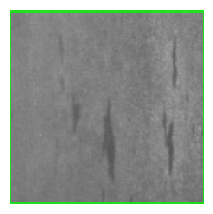

/content/super-gradients/src/super_gradients/training/utils/visualization/utils.py:67: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("gist_rainbow", num_classes)


In [ ]:
from super_gradients.training import utils as sg_utils
from PIL import Image

def predict_with_resizing(model, image_path, conf=0.3):
    """
    Predicts using the provided model, ensuring the image is resized to a multiple of 32.

    Args:
        model: The model to use for prediction.
        image_path: Path to the image.
        conf: Confidence threshold for predictions.

    Returns:
        Predictions for the image.
    """
    # Open the image using Pillow
    image = Image.open(image_path)

    # Get original dimensions
    width, height = image.size

    # Calculate new dimensions that are multiples of 32
    new_width = (width // 32 + (width % 32 > 0)) * 32
    new_height = (height // 32 + (height % 32 > 0)) * 32

    # Resize the image
    resized_image = image.resize((new_width, new_height))
    # Convert the PIL image to a NumPy array
    image_np = np.array(resized_image)

    # Perform prediction using the resized image
    predictions = model.predict(image_np, conf=conf)

    # You might need to adjust bounding box coordinates based on the resizing
    # if you want to display them on the original image.
    return predictions


# Replace the original prediction line with this:
predict_with_resizing(best_model, '/content/gdrive/MyDrive/Colab Notebooks/YOLO/NEU dataset/test/images/inclusion_93.jpg', conf=0.3).show()